Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

In [2]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the encoder class has to be somewhere other than the current notebook
# from ipynb.fs.defs.cat_encoder import CatEncoder # <- doesn't work on Azure Notebooks
# %run cat_encoder.py # <- doesn't work because code doesn't remain external

# Azure Notebooks workaround - 
import os
import sys
sys.path.append("../utils")
from cat_encoder import CatEncoder

In [3]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

# Since we're exploring fairness by unawareness we'll do several analyses.  In the original
# dataset the model has access to the protected grouping features of 'age' and 'status'.  We will explore
# two variations:
# 
# Firstly we'll build a model that does not have access to the protected features and see to waht degree
# that imporves fairness (this is fairness by unawareness)
# Secondly we'll add an extra protected feature ('pseudo') which is randomly assigned and thus has no correlation
# to anything else - this will act as a baseline for how fair we could expect a model to be that truly has no
# information about a protected feature even through correlated features
omitted_features = ['status', 'age', 'pseudo']

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'others',
    'status',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign',
    'pseudo'
    ]

#deterministic results
np.random.seed(0)

# Add pseudo-feature randomly
perm = np.random.permutation(len(df))
A_idx = perm[:int(len(df)/2)]
B_idx = perm[int(len(df)/2):]
pseudo_feature = np.empty(len(df), dtype=object)
pseudo_feature[A_idx] = 'A'
pseudo_feature[B_idx] = 'B'
df['pseudo'] = pseudo_feature

label_column = 'outcome'

# normalize the numeric columns
num_columns = [f for f in df.columns if (f not in cat_columns) and (f != label_column)]
from sklearn.preprocessing import Normalizer
numerics = df[num_columns]
normed = Normalizer().fit_transform(numerics)
df[num_columns] = normed

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

# Build models on both the reduced dataset and the full one

# Drop the omitted column(s) and train a model without them
X_reduced = X.drop(omitted_features, axis=1)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)
encoder_reduced = CatEncoder([f for f in cat_columns if f not in omitted_features], X_reduced)

# Measure accuracy for a constant predict-mode classifier
print(f"Accuracy of modal predictor: {sum(y == 1)/len(y)}")

def build_model(data, name):
    parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
    svc = svm.SVC()
    model = GridSearchCV(svc, parameters, cv=3)
    model.fit(data, y)

    # Assess on the full data
    accuracy = model.score(data, y.values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

model = build_model(encoder(X.values), 'aware')
model_unaware = build_model(encoder_reduced(X_reduced.values), 'unaware')


Accuracy of modal predictor: 0.7
Model 'aware' accuracy is 0.82
Model 'unaware' accuracy is 0.818


In [4]:
# Wrap the model up for use by Certifai as a local model
model_proxy = CertifaiPredictorWrapper(model, encoder=encoder)
model_proxy_unaware = CertifaiPredictorWrapper(model_unaware, encoder=encoder_reduced)


In [5]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

# Add our local model
first_model = CertifaiModel('aware',
                            local_predictor=model_proxy)
scan.add_model(first_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df))
scan.add_dataset(eval_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity in the features we hid from the model
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('pseudo'))
scan.add_evaluation_type('explanation')
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'
scan.explanation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: '680806f5e616'
[--------------------] 2020-05-29 09:25:30.232202 - 0 of 2 reports (0.0% complete) - Running explanation evaluation for model: aware
[##########----------] 2020-05-29 10:17:26.736748 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: aware


2020-05-29 10:17:26,797 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-29 10:18:53,675 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-29 10:19:34,437 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-29 10:20:49,446 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-29 10:21:42,215 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-29 10:22:20,658 root   WARNING  Examples of protected class (20, 'B') exhausted before convergence after 500 samples
2020-05-29 10:22:20,659 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before co

[####################] 2020-05-29 10:23:00.894980 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [6]:
# Repeat for the reduced model
# Note - we have to do this as a separate analysis because we're using models with a different
# signature (so a different schema) which cannot be encompassed in a single scan
scan.remove_model('aware')
reduced_model = CertifaiModel('unaware',
                            local_predictor=model_proxy_unaware)
scan.add_model(reduced_model)

# Tell Certifai the fields which we omitted from the model
scan.dataset_schema.hidden_feature_names = omitted_features

result2 = scan.run(write_reports=False)

[--------------------] 2020-05-29 10:23:00.984568 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'test_user_case' and scan_id: '4cd6b7e16453'
[--------------------] 2020-05-29 10:23:00.985252 - 0 of 2 reports (0.0% complete) - Running explanation evaluation for model: unaware
[##########----------] 2020-05-29 10:48:59.574532 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: unaware


2020-05-29 10:48:59,635 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-29 10:50:16,213 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-29 10:50:48,027 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-29 10:51:55,036 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-29 10:52:30,621 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-29 10:52:46,597 root   WARNING  Examples of protected class (20, 'B') exhausted before convergence after 500 samples
2020-05-29 10:52:46,597 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before co

[####################] 2020-05-29 10:53:10.143874 - 2 of 2 reports (100.0% complete) - Completed all evaluations


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
aware (burden),aware,burden,63.708700,54.786179,72.09618,64.832232,54.965841,75.267811,0.063724,0.051932,...,0.07116,0.059138,0.037988,0.090579,0.021466,0.012298,0.035767,0.030478,0.025192,0.044683
unaware (burden),unaware,burden,72.889211,61.363947,82.37233,79.967853,68.370229,92.668085,0.049897,0.039665,...,0.06724,0.027161,0.013280,0.045677,0.018550,0.009153,0.032022,0.034211,0.028748,0.049115


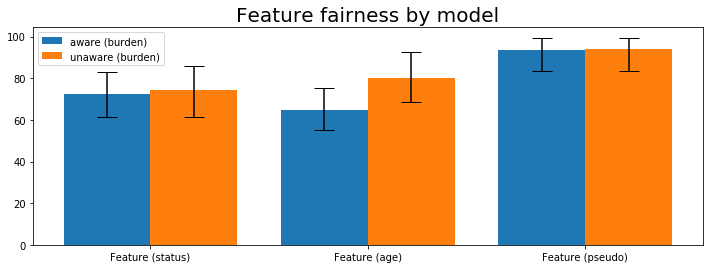

In [7]:
# Compare the fairness by feature measured for each model
df = pd.concat([construct_scores_dataframe(scores('fairness', result, max_depth=1)),
                construct_scores_dataframe(scores('fairness', result2, max_depth=1))])

display(df)

print("\n")

%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)', 'Feature (pseudo)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

ax.legend()
plt.show()

As expected the 'unaware' model improves in fairness on the 'aware' one, but still displays significant bias compared to the by-construction fair predictor.  This shows that simply removing a model's direct access to a feature can be helpful, but is far from a panacea.  In particular in this case we can see that bias on marital status remains within the confidence interval of the 'aware' model.